**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Write your code here
import numpy as np
import pandas as pd
from types import SimpleNamespace
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar, root


plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2
from Q1_full import ProductionEconomy
from Q2 import CareerClass
from Q3 import BarycentricInterpolation

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [3]:
# Set up the economy with initial parameters
economy = ProductionEconomy(par)

# Define price ranges
p1_range = np.linspace(0.1, 2.0, 10)
p2_range = np.linspace(0.1, 2.0, 10)

# Check market clearing
clearing_solutions = economy.check_market_clearing(p1_range, p2_range, threshold=1e-1)

# Print results
if clearing_solutions:
    print(f"Found {len(clearing_solutions)} clearing solution(s):")
    for solution in clearing_solutions:
        print(f"p1: {solution['p1']:.4f}, p2: {solution['p2']:.4f}")
        print(f"Labor diff: {solution['labor_diff']:.8f}")
        print(f"Good 1 diff: {solution['good1_diff']:.8f}")
        print(f"Good 2 diff: {solution['good2_diff']:.8f}")
        print()
else:
    print("No clearing solutions found within the specified threshold.")

Found 1 clearing solution(s):
p1: 0.9444, p2: 1.5778
Labor diff: -0.06180772
Good 1 diff: 0.04518395
Good 2 diff: -0.06622064



Question 1 and question 2 represent Discrete Grid vs. Continuous Search. 
In the first method, we were searching over a discrete grid of prices (using linspace). This meant we could only find solutions that happened to fall exactly on our grid points. To find a solution solution, we had to set the threshold so that our clearing remained rather imprecise. The resolution of the grid limited our accuracy.
The root-finding method, which we shall utilise next, on the other hand, can search continuously within the price space, allowing it to find exact solutions that might fall between the grid points of the first method. Our clearing is much better, as a result. 

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [4]:
initial_guess = [1.0, 1.0]  
equilibrium_prices = economy.find_equilibrium_prices(initial_guess)

if equilibrium_prices is not None:
    p1_eq, p2_eq = equilibrium_prices
    print(f"Equilibrium prices found:")
    print(f"p1 = {p1_eq:.6f}")
    print(f"p2 = {p2_eq:.6f}")
    
    # Verify all market clearing conditions
    economy.set_prices(p1_eq, p2_eq)
    labor_diff, good1_diff, good2_diff = economy.market_clearing()
    print("\nMarket clearing conditions:")
    print(f"Labor market diff: {labor_diff:.8f}")
    print(f"Good 1 market diff: {good1_diff:.8f}")
    print(f"Good 2 market diff: {good2_diff:.8f}")
else:
    print("Failed to find equilibrium prices.")

Equilibrium prices found:
p1 = 0.975931
p2 = 1.490759

Market clearing conditions:
Labor market diff: 0.00000000
Good 1 market diff: 0.00000000
Good 2 market diff: 0.00000000


Using Walras' Law and only solving for two market conditions, we greatly reduce the complexity of the problem and avoid potential numerical issues that might arise from trying to simultaneously satisfy three conditions that are not independent.

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [24]:
# Find optimal tax
optimal_tau_A = economy.optimize_tax()

if optimal_tau_A is not None:
    print(f"Optimal tax (tau): {optimal_tau_A:.6f}")
    
    # Calculate and display the implied transfer
    equilibrium_prices = economy.find_equilibrium_prices([1.0, 1.0])
    if equilibrium_prices is not None:
        economy.p1, economy.p2 = equilibrium_prices
        ell_star = economy.optimal_labor_supply()
        _, c2_star = economy.optimal_consumption(ell_star)
        optimal_T = optimal_tau_A * c2_star
        print(f"Implied transfer (T): {optimal_T:.6f}")
        
        # Display the SWF at the optimal tax
        optimal_swf = economy.calculate_swf(optimal_tau_A)
        print(f"Social Welfare Function value: {optimal_swf:.6f}")
    else:
        print("Failed to find equilibrium prices for the optimal tax.")
else:
    print("Failed to find optimal tax.")

Optimal tax (tau): 0.190416
Implied transfer (T): 0.139567
Social Welfare Function value: -0.660068


To be on the safe side, we cross-validate - trying to get at the optimal tax rate using a different method. Ideally, the two methods should yield the same result. 

In [26]:
optimal_tau_B, optimal_T_B = economy.optimize_social_welfare()

if optimal_tau_B is not None:
    
    print(f"Optimal tau: {optimal_tau_B:.6f}")
    print(f"Optimal Transfer T: {optimal_T:.6f}")
else:
    print("Failed to find optimal tau.")

Optimal tau: 0.190406
Optimal Transfer T: 0.139567


We create a visual to show the results. We intend to show that the optimal tax-rate coincides with where the Social Welfare Function is maximised.

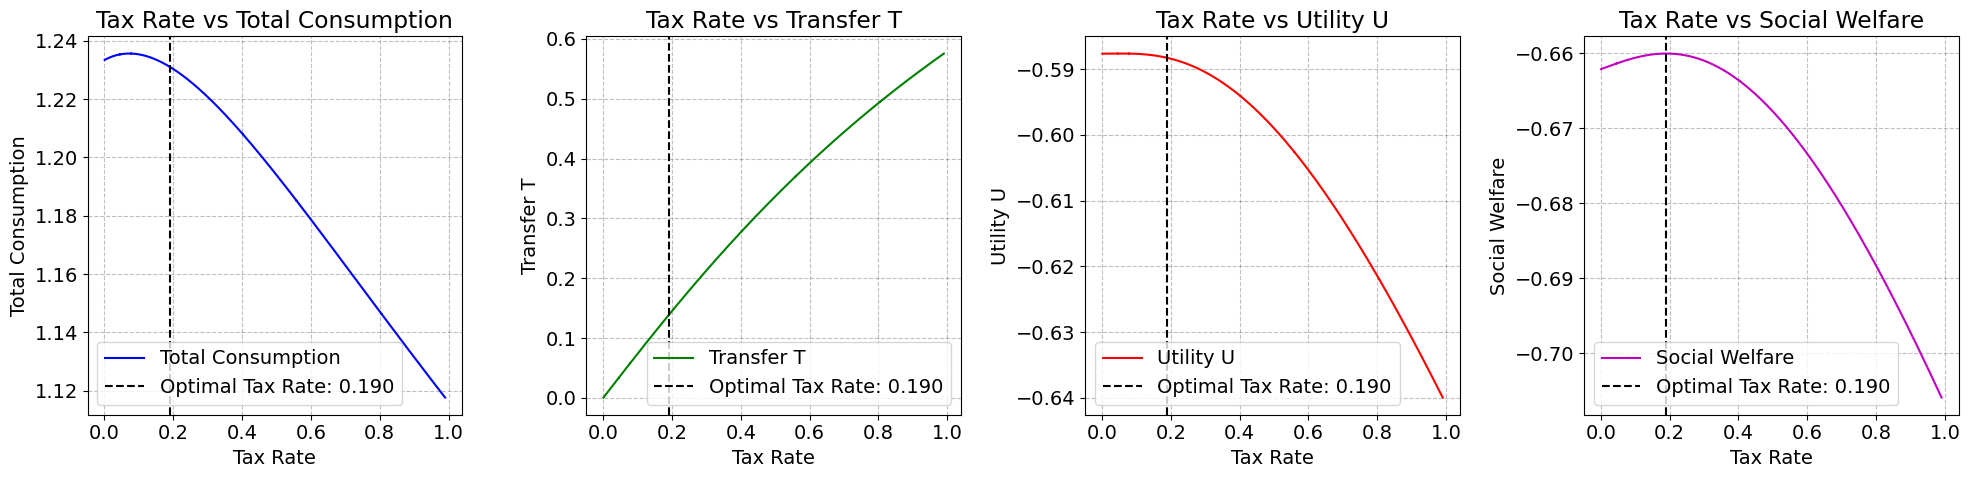

In [27]:
economy.plot_tax_rate_impact()

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [8]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [9]:
career = CareerClass()
career.simulate()

Career track 1:
Expected utility: 0.9720
Average realized utility: 0.9720
-----------
Career track 2:
Expected utility: 1.9783
Average realized utility: 1.9783
-----------
Career track 3:
Expected utility: 2.9522
Average realized utility: 2.9522
-----------


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

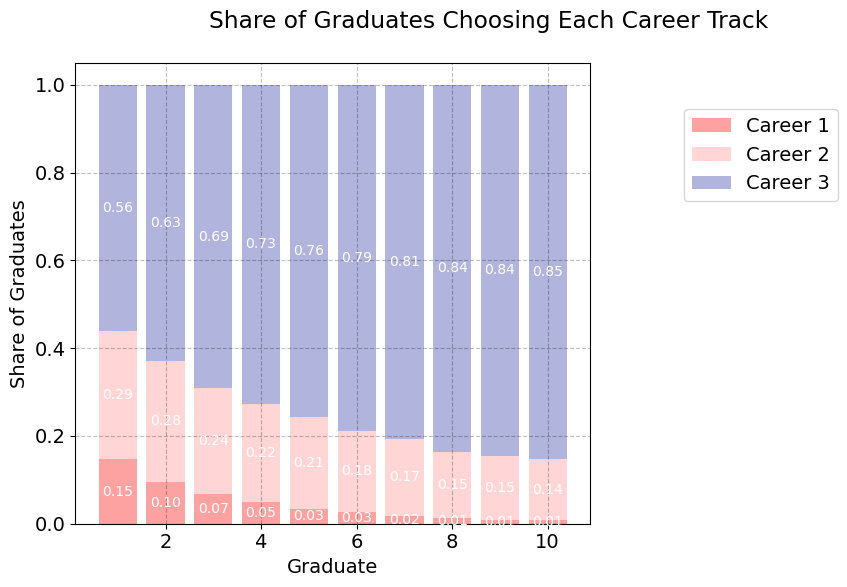

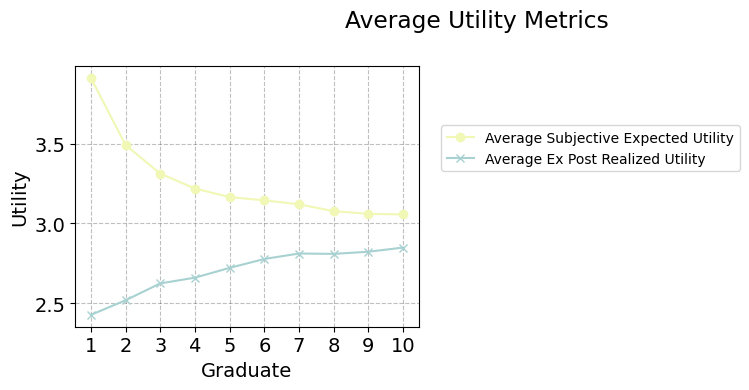

In [10]:
chose_car, p_expect, real_u = career.simulate_friend()
shares_g, avg_sub_expect_u, avg_ex_post_real_u = career.calculate_metrics(chose_car, p_expect, real_u)
career.plot_shares(shares_g)
career.plot_utilities(avg_sub_expect_u, avg_ex_post_real_u)

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

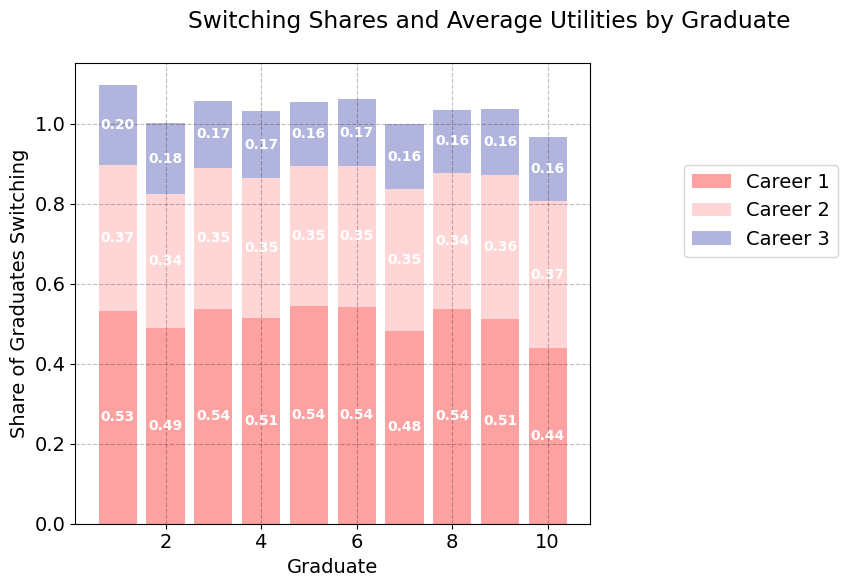

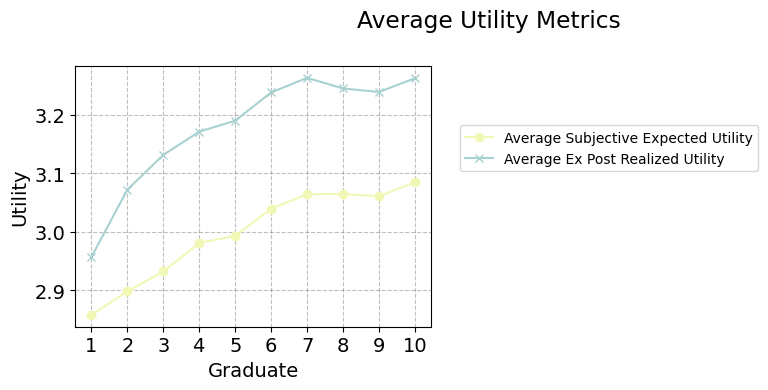

In [11]:

chose_car_i, p_expect_s, real_u_s, switched_career = career.simulate_switch()
switch_shares, avg_sub_expect_u_s, avg_ex_post_real_u_s = career.calculate_switch_metrics(chose_car_i, p_expect_s, real_u_s, switched_career)
career.plot_switch_share(switch_shares)
career.plot_utilities_switch(avg_sub_expect_u_s, avg_ex_post_real_u_s)

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [12]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

We generate 50 random function values for the 50 points in X. These values are dummy values for illustration purposes. We initialise the BarycentricInterpolation object with the generated points X and their corresponding dummy function values. We call the **compute_closest_points** method to find the closest points A, B, C, and D around the query point, y. We print coordinates and **plot** method to visualize the points and the triangles formed by A, B, C, and D.

Our query point, y, is plotted as a red dot. The closest points: A, B, C, and D around the query point are plotted in different colors. Triangle ABC is filled with light blue color, showing the region used for barycentric interpolation if the query point y lies inside it. Triangle CDA, filled with light green color, showing the alternate region for interpolation if the query point conversely lies inside this triangle.

A: [0.26071605 0.43635845]
B: [0.21315735 0.274245  ]
C: [0.10056103 0.27951775]
D: [0.20634391 0.44272557]


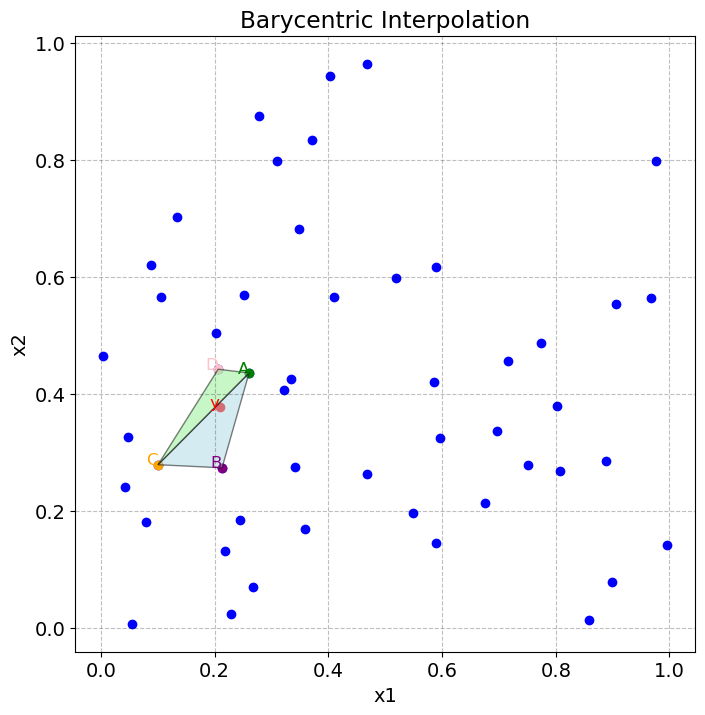

In [13]:
from Q3 import BarycentricInterpolation

#Dummy values for illustration
f_values = rng.uniform(size=(50,))

#Answer
interpolator = BarycentricInterpolation(X, f_values)
A, B, C, D = interpolator.compute_closest_points(y)
print("A:", A)
print("B:", B)
print("C:", C)
print("D:", D)

# Plot the points and the triangles
interpolator.plot(y)

#### Understanding the Algorithm 

The algorithm calculates the barycentric coordinates of \( y \) with respect to each triangle. Barycentric coordinates \( (r_1, r_2, r_3) \) express \( y \) as a weighted sum of the vertices of the triangle.

#### Determine Containment

The barycentric coordinates are checked to see if \( y \) lies within triangle \( ABC \) (i.e., all coordinates are between 0 and 1). If \( y \) does not lie within \( ABC \), the algorithm checks triangle \( CDA \).

#### Interpolation

If \( y \) lies within triangle \( ABC \):

\[
f(y) \approx r_1 f(A) + r_2 f(B) + r_3 f(C)
\]

If \( y \) lies within triangle \( CDA \):

\[
f(y) \approx r_1 f(C) + r_2 f(D) + r_3 f(A)
\]

If \( y \) lies outside both triangles, interpolation is not possible.

#### Summary

The triangles \( ABC \) and \( CDA \) provide the geometric framework to express the query point \( y \) in terms of the function values at the vertices, allowing for an interpolated approximation of \( f(y) \).

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [14]:
# Find barycentric coordinates and determine the triangle
triangle, coordinates = interpolator.find_triangle_and_coordinates(y)
print(f"Point y is inside triangle {triangle}")
if coordinates:
    print("Barycentric coordinates:", coordinates) 

Point y is inside triangle ABC
Barycentric coordinates: (0.6286263152916166, 0.06910145494351515, 0.3022722297648682)


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [15]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

We understand this as if we are being asked to calculate interpolated values for all 50 points. We hold these up against the true values, we list the difference - as well as which triangle the points fit into. We present results in a table below. 

In [16]:
# Initialize the interpolator without verbose mode
interpolator = BarycentricInterpolation(X, F, verbose=False)

# Create a DataFrame to store the results
results = []

# Iterate over each point in X, compute the true value, interpolated value, and the difference
for i, x in enumerate(X):
    true_value = f(x)
    try:
        interpolated_value = interpolator.interpolate(x)
        if np.isnan(interpolated_value):
            raise ValueError("Interpolation returned NaN")
        triangle, coords = interpolator.find_triangle_and_coordinates(x)
    except Exception as e:
        interpolated_value = None
        triangle = "None"
    
    difference = true_value - interpolated_value if interpolated_value is not None else None
    
    results.append({
        "Point": f"({x[0]:.3f}, {x[1]:.3f})",
        "True Value": true_value,
        "Interpolated Value": interpolated_value,
        "Difference": difference,
        "Triangle": triangle
    })

# Convert the results to a DataFrame
df_results = pd.DataFrame(results)

# Format the DataFrame to show values with three decimal places
df_results["True Value"] = df_results["True Value"].round(3)
df_results["Interpolated Value"] = df_results["Interpolated Value"].round(3)
df_results["Difference"] = df_results["Difference"].round(3)

# Display the DataFrame
df_results.index = [f"X{i+1}" for i in range(len(df_results))]
print(df_results)

              Point  True Value  Interpolated Value  Difference Triangle
X1   (0.676, 0.214)       0.145               0.150      -0.005      ABC
X2   (0.309, 0.799)       0.247               0.253      -0.006      ABC
X3   (0.996, 0.142)       0.142                 NaN         NaN     None
X4   (0.079, 0.181)       0.014               0.017      -0.002      CDA
X5   (0.360, 0.170)       0.061               0.070      -0.009      CDA
X6   (0.589, 0.617)       0.363               0.372      -0.009      ABC
X7   (0.105, 0.566)       0.060               0.063      -0.004      ABC
X8   (0.005, 0.465)       0.002                 NaN         NaN     None
X9   (0.976, 0.799)       0.780                 NaN         NaN     None
X10  (0.597, 0.325)       0.194               0.196      -0.002      CDA
X11  (0.206, 0.443)       0.091               0.099      -0.008      ABC
X12  (0.278, 0.875)       0.243                 NaN         NaN     None
X13  (0.213, 0.274)       0.058               0.059

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [17]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [18]:
for y in Y:
    try:
        approximated_value = interpolator.interpolate(y)
        if np.isnan(approximated_value):
            raise ValueError("Interpolation returned NaN")
    except Exception as e:
        approximated_value = None
        print(f"Error occurred while processing point {y}: {e}")

    true_value = f(y)
    if approximated_value is not None:
        print(f"Point y: {y}")
        print(f"Approximated value of f(y): {approximated_value:.4f}")
        print(f"True value of f(y): {true_value:.4f}")
    else:
        print(f"Point y: {y}")
        print(f"Approximated value of f(y): {approximated_value}")
        print(f"True value of f(y): {true_value:.4f}")
    print()

Point y: (0.2, 0.2)
Approximated value of f(y): 0.0403
True value of f(y): 0.0400

Point y: (0.8, 0.2)
Approximated value of f(y): 0.1587
True value of f(y): 0.1600

Error occurred while processing point (0.8, 0.8): Interpolation returned NaN
Point y: (0.8, 0.8)
Approximated value of f(y): None
True value of f(y): 0.6400

Point y: (0.8, 0.2)
Approximated value of f(y): 0.1587
True value of f(y): 0.1600

Point y: (0.5, 0.5)
Approximated value of f(y): 0.2513
True value of f(y): 0.2500



(As was the case in Q3.3) We have difficulties interpolating one of the points above. We are lacking an "A". To see, if this is a problem with the algorithm, or with the size of the sample, we amend our sample to make the grid finer. In so far as the sample size is the issue, we expect this to solve the problem, making it possible to create interpolations for all points in the list. For the algorithm to work we need all four points. 

In [19]:
f = lambda x: x[0] * x[1]

# Generate a larger set of random points and their function values
rng = np.random.default_rng(2024)
X = rng.uniform(size=(500, 2))
F = np.array([f(x) for x in X])

# Define again the set of points Y
Y = [(0.2, 0.2), (0.8, 0.2), (0.8, 0.8), (0.8, 0.2), (0.5, 0.5)]

# Initialize the interpolator
interpolator = BarycentricInterpolation(X, F)

# Iterate over each point in Y, compute the approximation and compare with the true value
for y in Y:
    try:
        approximated_value = interpolator.interpolate(y)
        if np.isnan(approximated_value):
            raise ValueError("Interpolation returned NaN")
    except Exception as e:
        approximated_value = None
        print(f"Error occurred while processing point {y}: {e}")

    true_value = f(y)
    if approximated_value is not None:
        print(f"Point y: {y}")
        print(f"Approximated value of f(y): {approximated_value:.4f}")
        print(f"True value of f(y): {true_value:.4f}")
    else:
        print(f"Point y: {y}")
        print(f"Approximated value of f(y): {approximated_value}")
        print(f"True value of f(y): {true_value:.4f}")
    print()


Point y: (0.2, 0.2)
Approximated value of f(y): 0.0401
True value of f(y): 0.0400

Point y: (0.8, 0.2)
Approximated value of f(y): 0.1601
True value of f(y): 0.1600

Point y: (0.8, 0.8)
Approximated value of f(y): 0.6396
True value of f(y): 0.6400

Point y: (0.8, 0.2)
Approximated value of f(y): 0.1601
True value of f(y): 0.1600

Point y: (0.5, 0.5)
Approximated value of f(y): 0.2500
True value of f(y): 0.2500



This appears to have solved the problem. 